In [123]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import copy

In [2]:
ticker = "BTC-USD"
data = yf.download("BTC-USD", start="2020-01-01", end=pd.Timestamp.now().strftime('%Y-%m-%d'))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Посмотрим какие данные у нас присутствуют

In [10]:
data

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095
...,...,...,...,...,...
2025-06-03,105432.468750,106813.578125,104920.843750,105888.476562,46196508367
2025-06-04,104731.984375,105997.695312,104232.703125,105434.367188,44544857105


Логично использовать все данные для работы модели, так как все они даже из логики могут влиять на Close, по метрикам увидим правильность этого решения

In [11]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [87]:
data

Price,Open,High,Low,Close,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095
...,...,...,...,...,...
2025-06-03,105888.476562,106813.578125,104920.843750,105432.468750,46196508367
2025-06-04,105434.367188,105997.695312,104232.703125,104731.984375,44544857105


In [86]:
np.array(data)

array([[7.19489209e+03, 7.25433057e+03, 7.17494434e+03, 7.20017432e+03,
        1.85656650e+10],
       [7.20255127e+03, 7.21215527e+03, 6.93527002e+03, 6.98547021e+03,
        2.08020835e+10],
       [6.98442871e+03, 7.41371533e+03, 6.91499609e+03, 7.34488428e+03,
        2.81114810e+10],
       ...,
       [1.04750781e+05, 1.05936688e+05, 1.00436883e+05, 1.01575953e+05,
        5.74792984e+10],
       [1.01574367e+05, 1.05376773e+05, 1.01169570e+05, 1.04390344e+05,
        4.88566537e+10],
       [1.04390648e+05, 1.05972758e+05, 1.03987312e+05, 1.05615625e+05,
        3.83650338e+10]])

In [143]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Функция создания последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [144]:
seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

In [145]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [146]:
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super(BitcoinLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        return self.fc(last_time_step)

Убрали нулевую инициализацию весов, которая была в изначальной модели
Также видно, что в моделе теперь выход размерности 5, это нужно нам для предсказания на 30 дней

In [155]:
input_size = 5
out_size = 5
hidden_size = 64
num_layers = 2
lr = 0.001
epochs = 100

In [156]:
model = BitcoinLSTM(input_size, hidden_size, num_layers, out_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [157]:
loss_history = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 0.065136
Epoch 10, Loss: 0.018047
Epoch 20, Loss: 0.012378
Epoch 30, Loss: 0.007617
Epoch 40, Loss: 0.003078
Epoch 50, Loss: 0.002114
Epoch 60, Loss: 0.001455
Epoch 70, Loss: 0.001179
Epoch 80, Loss: 0.001065
Epoch 90, Loss: 0.000993


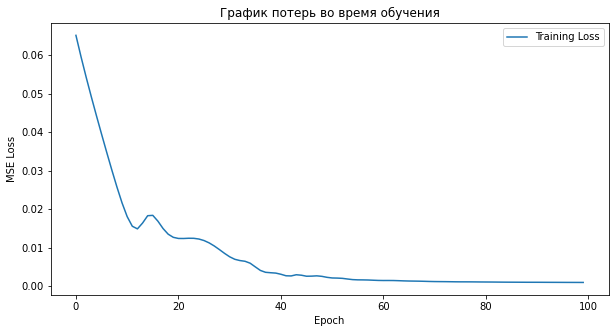

In [158]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("График потерь во время обучения")
plt.legend()
plt.show()

In [159]:
model.eval()
test_predictions = model(X_test).detach().numpy()
test_predictions_inv = scaler.inverse_transform(test_predictions)
y_test_inv = scaler.inverse_transform(y_test.numpy())

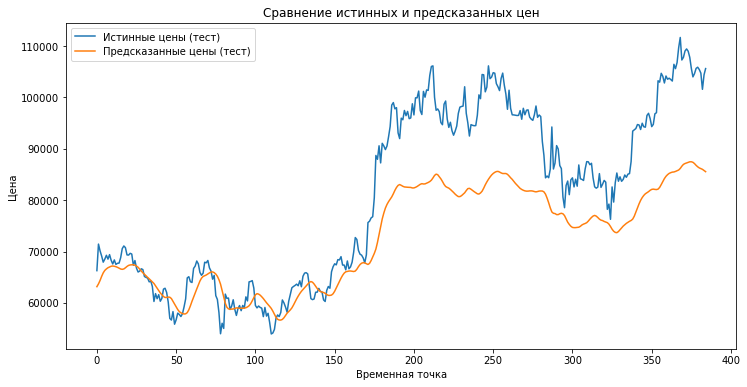

In [160]:
# Визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 3], label="Истинные цены (тест)")
plt.plot(test_predictions_inv[:, 3], label="Предсказанные цены (тест)")
plt.xlabel("Временная точка")
plt.ylabel("Цена")
plt.title("Сравнение истинных и предсказанных цен")
plt.legend()
plt.show()

In [161]:
def forecast(model, last_sequence, days=30):
    model.eval()
    predictions = []
    current_seq = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0)

    for _ in range(days):
        next_pred = model(current_seq)
        predictions.append(next_pred.detach().numpy()[0])
        current_seq = torch.cat((current_seq[:, 1:, :], next_pred.unsqueeze(0)), dim=1)

    return predictions

(30, 5)


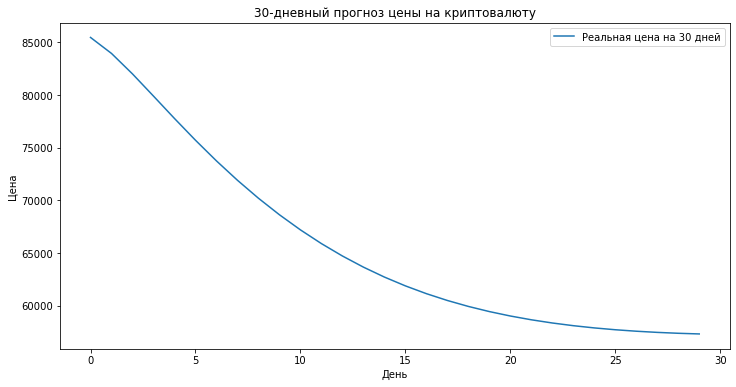

In [162]:
# Прогноз на 30 дней
last_sequence = scaled_data[-seq_length:]
scaled_forecast = forecast(model, last_sequence, days=30)
scaled_forecast = np.array(scaled_forecast)
print(scaled_forecast.shape)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast))[:, 3]

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(forecast_prices, label="Реальная цена на 30 дней")
plt.xlabel("День")
plt.ylabel("Цена")
plt.title("30-дневный прогноз цены на криптовалюту")
plt.legend()
plt.show()

Очевидно, что даже при таких изменениях - прогноз на 30 дней, скорее всего, не корректен, попробуем поменять параметры модели, то есть увеличить число скрытых состояний и слоев, а для борьбы с переобучением добавим валидацию в процессе, и будем сохранять модель, дающую лучший результат на валидации

In [170]:
input_size = 5
out_size = 5
hidden_size = 64
num_layers = 5
lr = 0.001
epochs = 200

model = BitcoinLSTM(input_size, hidden_size, num_layers, out_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [171]:
def eval(model, X_test, y_test):
    model.eval()
    test_predictions = model(X_test).detach().numpy()
    val = 0
    for y, y_pred in zip(y_test[:, 3], test_predictions[:, 3]):
        val += (y - y_pred) ** 2
    val /= y_test_inv.shape[0]
    return val

In [175]:
loss_history = []
best_model = None
best_score = 100.0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

        eval_val = eval(model, X_test, y_test)
        print(f"Epoch {epoch}, Eval: {eval_val}")
        if best_score > eval_val:
            best_score = eval_val
            best_model = copy.deepcopy(model)

Epoch 0, Loss: 0.000958
Epoch 0, Eval: 0.007101638708263636
Epoch 10, Loss: 0.000944
Epoch 10, Eval: 0.0071323891170322895
Epoch 20, Loss: 0.000933
Epoch 20, Eval: 0.007313312031328678
Epoch 30, Loss: 0.000988
Epoch 30, Eval: 0.00584666570648551
Epoch 40, Loss: 0.000935
Epoch 40, Eval: 0.008548328652977943
Epoch 50, Loss: 0.000921
Epoch 50, Eval: 0.006855540908873081
Epoch 60, Loss: 0.000896
Epoch 60, Eval: 0.0066564008593559265
Epoch 70, Loss: 0.000885
Epoch 70, Eval: 0.006602631416171789
Epoch 80, Loss: 0.000876
Epoch 80, Eval: 0.006441962905228138
Epoch 90, Loss: 0.000866
Epoch 90, Eval: 0.006136658135801554
Epoch 100, Loss: 0.000856
Epoch 100, Eval: 0.0060503496788442135
Epoch 110, Loss: 0.000847
Epoch 110, Eval: 0.005984804127365351
Epoch 120, Loss: 0.000838
Epoch 120, Eval: 0.006008503492921591
Epoch 130, Loss: 0.001033
Epoch 130, Eval: 0.007923061028122902
Epoch 140, Loss: 0.000898
Epoch 140, Eval: 0.005883603356778622
Epoch 150, Loss: 0.000822
Epoch 150, Eval: 0.005849766544997

(30, 5)


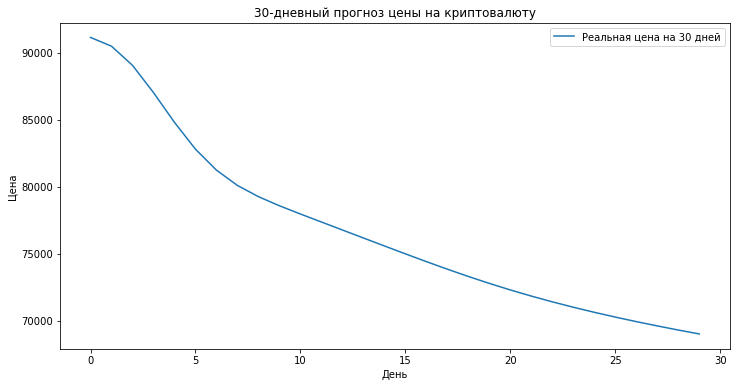

In [180]:
# Прогноз на 30 дней
last_sequence = scaled_data[-seq_length:]
scaled_forecast = forecast(best_model, last_sequence, days=30)
scaled_forecast = np.array(scaled_forecast)
print(scaled_forecast.shape)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast))[:, 3]

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(forecast_prices, label="Реальная цена на 30 дней")
plt.xlabel("День")
plt.ylabel("Цена")
plt.title("30-дневный прогноз цены на криптовалюту")
plt.legend()
plt.show()

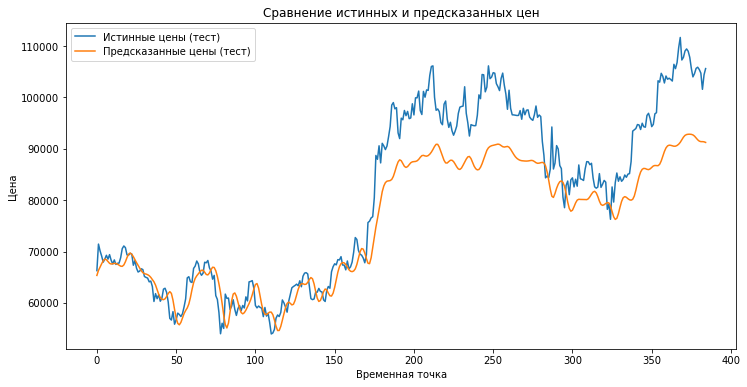

In [181]:
model.eval()
test_predictions = best_model(X_test).detach().numpy()
test_predictions_inv = scaler.inverse_transform(test_predictions)
y_test_inv = scaler.inverse_transform(y_test.numpy())

# Визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 3], label="Истинные цены (тест)")
plt.plot(test_predictions_inv[:, 3], label="Предсказанные цены (тест)")
plt.xlabel("Временная точка")
plt.ylabel("Цена")
plt.title("Сравнение истинных и предсказанных цен")
plt.legend()
plt.show()

Прогноз на 30 дней все еще плохой, но предсказания на тестовых ценах стали лучше

Что было сделано:
1. Учитывались все 5 полей из данных.
2. Изменены параметры модели, добавлено больше слоев, увеличена размерность скрытого слоя.
3. Увеличили количество эпох.
4. Добавлена валидация в процессе обучения для борьбы с переобучением.